In [124]:
from collections import Counter
from pysurvival.utils.display import correlation_matrix
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
def load_data(fp='.'):

    # Sensor data
    data = pd.read_csv(fp + '/PdM_telemetry.csv.gz')

    # Error alarm logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_errors.csv.gz'),
        how='left', on=['datetime', 'machineID'])

    # Failure logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_failures.csv.gz'),
        how='left', on=['datetime', 'machineID'])

    # Formatting
    data.datetime = pd.to_datetime(data.datetime)

    return data

In [5]:
raw_data = load_data()
raw_data.head(10)

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,NaN,NaN
5,2015-01-01 11:00:00,1,172.504839,430.323362,95.927042,35.655017,NaN,NaN
6,2015-01-01 12:00:00,1,156.556031,499.071623,111.755684,42.753920,NaN,NaN
7,2015-01-01 13:00:00,1,172.522781,409.624717,101.001083,35.482009,NaN,NaN
8,2015-01-01 14:00:00,1,175.324524,398.648781,110.624361,45.482287,NaN,NaN
9,2015-01-01 15:00:00,1,169.218423,460.850670,104.848230,39.901735,NaN,NaN


In [136]:
def generate_run_to_failure(raw_data):

    run_to_failure = []
    error_ids = raw_data.errorID.dropna().sort_values().unique().tolist()

    for machine_id, g in tqdm.tqdm(raw_data.groupby('machineID'), desc='run-to-failure'):
        g = g.set_index('datetime').sort_index()

        start_date = g.index.values[0]
        failures = g.loc[~g.failure.isnull()]

        for event_time, event in failures.iterrows():
            # Extracting a single cycle/process
            cycle = g[start_date:event_time].drop('machineID', axis=1)

            lifetime = (event_time - start_date).days
            if lifetime < 1:
                start_date = event_time
                continue

            numerical_features = cycle.agg(['min', 'max', 'mean']).unstack().reset_index()
            numerical_features['feature'] = numerical_features.level_0.str.cat(numerical_features.level_1, sep='_')
            numerical_features = numerical_features.pivot_table(columns='feature', values=0)

            categorical_features = pd.DataFrame(Counter(cycle.errorID), columns=error_ids, index=[0])

            sample = pd.concat([numerical_features, categorical_features], axis=1)
            sample[['machine_id', 'lifetime', 'broken']] = machine_id, lifetime, 1

            run_to_failure.append(sample)
            start_date = event_time

    return pd.concat(run_to_failure, axis=0).fillna(0).reset_index(drop=True)

In [34]:
run_to_failure = generate_run_to_failure(raw_data)
print('dataset shape:', run_to_failure.shape)
run_to_failure.head(10)

run-to-failure: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]

dataset shape: (701, 19)


,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,lifetime,broken
0,127.014498,99.110599,75.237905,568.972310,448.442509,346.149335,66.764515,45.772916,25.990511,215.656488,171.083372,127.163620,1,0,1,0,1,4,1
1,129.872708,99.977032,58.733724,586.945963,449.450816,283.244579,57.235765,40.009107,22.666865,237.938518,171.848645,119.059047,2,1,0,3,0,60,1
2,149.495371,101.183144,66.056574,617.475389,448.987074,215.619476,57.854821,39.961899,23.068857,217.519065,171.440932,123.176157,2,2,1,0,0,45,1
3,155.257527,101.865501,68.959892,594.577052,447.325059,249.930318,61.150030,40.830460,24.574739,219.140220,170.800215,124.354369,2,1,2,2,1,60,1
4,149.331540,100.655984,68.564921,616.412968,449.062652,288.103612,67.633435,41.133677,24.337968,223.411619,170.034341,127.321876,1,0,2,0,1,75,1
5,133.374116,99.797936,67.837092,592.707013,433.068530,232.725578,62.381056,40.168281,24.169575,219.424909,169.897473,121.989015,3,2,2,0,0,45,1
6,153.185010,100.791414,59.544366,636.364569,444.849241,233.103497,61.899067,40.898746,24.481123,227.571839,171.418027,122.295439,0,0,1,0,1,60,1
7,150.848378,100.491928,70.375627,627.356257,443.969536,246.322521,63.796351,40.404857,22.078087,227.935370,170.977573,125.490362,2,2,1,2,0,77,1
8,135.347429,99.305421,69.222251,591.592508,436.866608,250.404219,59.417148,40.558199,24.267488,215.657450,169.206292,123.966971,0,2,2,0,0,30,1
9,150.005484,100.714720,65.093896,629.672001,447.990062,203.707820,64.097877,40.251689,24.080273,235.114772,170.863177,112.486614,3,6,2,3,3,255,1


<AxesSubplot:>

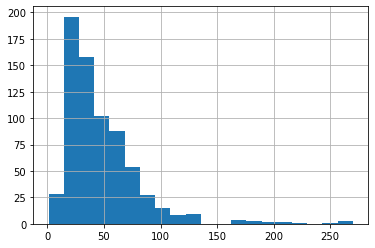

In [26]:
run_to_failure.lifetime.hist(bins=20)

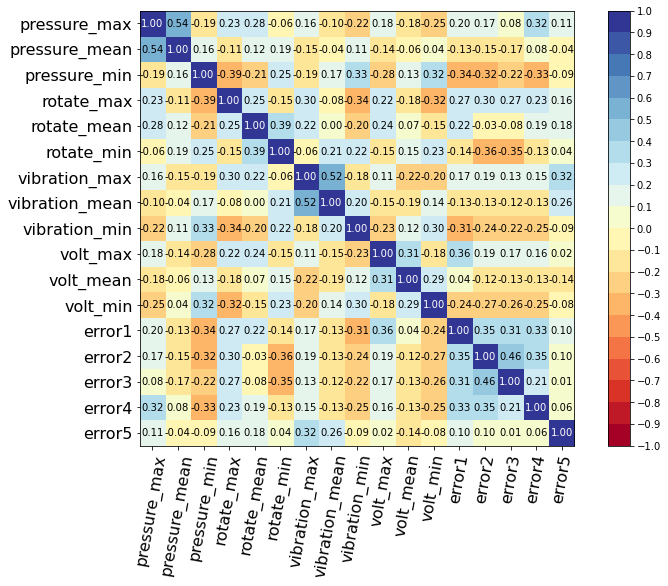

In [31]:
correlation_matrix(run_to_failure.drop(['lifetime', 'broken'], axis=1))

In [154]:
def cencoring_augmentation(raw_data, n_samples=10, max_lifetime=150, min_lifetime=2, seed=123):

    error_ids = raw_data.errorID.dropna().sort_values().unique().tolist()
    np.random.seed(seed)
    samples = []
    pbar = tqdm.tqdm(total=n_samples, desc='augmentation')

    while len(samples) < n_samples:
        
        cencor_timing = np.random.randint(min_lifetime, max_lifetime)
        machine_id = np.random.randint(100) + 1
        tmp = raw_data[raw_data.machineID == machine_id]
        tmp = tmp.drop('machineID', axis=1).set_index('datetime').sort_index()

        failures = tmp[~tmp.failure.isnull()]
        if failures.shape[0] < 2:
            continue

        failure_id = np.random.randint(failures.shape[0])
        failure = failures.iloc[failure_id]
        event_time = failure.name
        start_date = tmp.index.values[0] if failure_id == 0 else failures.iloc[failure_id - 1].name

        # cencoring
        cycle = tmp[start_date:event_time]
        cycle = cycle.iloc[:cencor_timing]

        if not cycle.shape[0] == cencor_timing:
            continue

        numerical_features = cycle.agg(['min', 'max', 'mean']).unstack().reset_index()
        numerical_features['feature'] = numerical_features.level_0.str.cat(numerical_features.level_1, sep='_')
        numerical_features = numerical_features.pivot_table(columns='feature', values=0)

        categorical_features = pd.DataFrame(Counter(cycle.errorID), columns=error_ids, index=[0])

        sample = pd.concat([numerical_features, categorical_features], axis=1)
        sample[['machine_id', 'lifetime', 'broken']] = machine_id, cencor_timing, 0
        samples.append(sample)
        pbar.update(1)

    pbar.close()
    return pd.concat(samples).reset_index(drop=True).fillna(0)

In [155]:
health_cencors = cencoring_augmentation(raw_data, n_samples=1000, max_lifetime=200, min_lifetime=3)
health_cencors

augmentation: 100%|██████████| 1000/1000 [00:14<00:00, 68.76it/s]


,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,machine_id,lifetime,broken
0,130.706018,100.236134,72.092543,586.941563,448.942591,338.891195,51.424300,39.794041,28.741474,212.028491,170.740329,136.291010,0,0,0,0,0,67,112,0
1,114.678705,101.231155,76.547574,522.074447,431.497500,307.778433,50.792066,40.492661,31.052696,195.527742,166.275130,135.888408,0,0,0,0,0,84,20,0
2,135.959689,100.077178,73.309133,581.808774,448.433424,345.686347,53.095653,40.262504,29.773657,211.858373,173.794237,134.905936,0,0,1,0,0,58,126,0
3,116.473551,98.781988,79.125328,531.943470,453.146862,300.562373,54.155983,39.554378,21.629032,208.756064,168.011703,132.177014,0,0,0,0,0,48,99,0
4,116.927449,97.906122,80.970162,553.496437,443.786734,306.918582,50.899053,39.540444,27.994116,210.998009,174.987418,133.822276,0,0,0,0,0,47,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,129.326828,100.226996,72.139048,563.773486,457.574190,304.169569,52.120127,39.739339,27.957389,209.944130,171.202096,136.707254,0,0,0,0,0,16,173,0
996,127.329025,100.172188,75.271758,565.169030,448.548975,338.088286,52.203383,39.610840,26.958497,207.817766,168.050700,130.010419,0,0,0,0,1,92,106,0
997,129.873496,100.316682,69.633305,591.043686,445.510045,314.715558,53.317967,39.476418,21.664048,219.621927,170.899436,134.810529,0,0,0,0,0,73,194,0
998,130.022835,99.306881,72.192132,561.416440,455.304072,325.983463,53.435171,39.743497,28.283177,212.944271,170.582113,130.316605,0,0,0,0,0,28,159,0


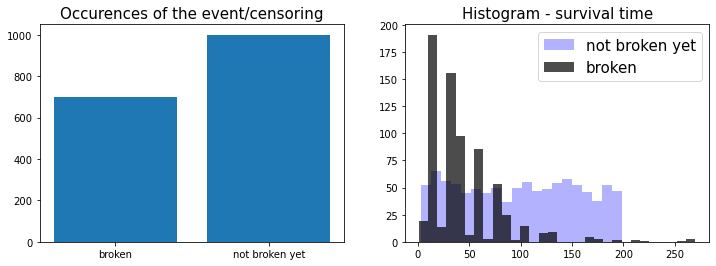

In [142]:
sample_data = pd.concat([run_to_failure, health_cencors])

# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(12, 4))

# Counting the number of occurrences for each category 
data = Counter(sample_data['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = sample_data.loc[ sample_data['broken'] == 0, 'lifetime']
ax2.hist(time_0, bins=20, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = sample_data.loc[ sample_data['broken'] == 1, 'lifetime']
ax2.hist(time_1, bins=30, alpha=0.7, color='black', label = 'broken')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

In [156]:
def generate_run_to_failure(raw_data, health_cencor_aug=1000, seed=123, outfn=None):

    run_to_failure = []
    error_ids = raw_data.errorID.dropna().sort_values().unique().tolist()

    for machine_id, g in tqdm.tqdm(raw_data.groupby('machineID'), desc='run-to-failure'):
        g = g.set_index('datetime').sort_index()

        start_date = g.index.values[0]
        failures = g.loc[~g.failure.isnull()]

        for event_time, event in failures.iterrows():
            # Extracting a single cycle/process
            cycle = g[start_date:event_time].drop('machineID', axis=1)

            lifetime = (event_time - start_date).days
            if lifetime < 1:
                start_date = event_time
                continue

            numerical_features = cycle.agg(['min', 'max', 'mean']).unstack().reset_index()
            numerical_features['feature'] = numerical_features.level_0.str.cat(numerical_features.level_1, sep='_')
            numerical_features = numerical_features.pivot_table(columns='feature', values=0)

            categorical_features = pd.DataFrame(Counter(cycle.errorID), columns=error_ids, index=[0])

            sample = pd.concat([numerical_features, categorical_features], axis=1)
            sample[['machine_id', 'lifetime', 'broken']] = machine_id, lifetime, 1

            run_to_failure.append(sample)
            start_date = event_time

    run_to_failure = pd.concat(run_to_failure, axis=0).fillna(0).reset_index(drop=True)
    health_censors = cencoring_augmentation(raw_data, n_samples=health_cencor_aug, seed=seed)
    run_to_failure = pd.concat([run_to_failure, health_censors])
    # Shuffle
    run_to_failure = run_to_failure.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    if outfn is not None:
        run_to_failure.to_csv(outfn, index=False)

    return run_to_failure

In [157]:
data = generate_run_to_failure(raw_data, health_cencor_aug=1000)

augmentation: 100%|██████████| 1000/1000 [00:14<00:00, 68.84it/s]


In [158]:
data.head(10)

,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,machine_id,lifetime,broken
0,124.020698,99.610640,80.226324,574.432065,451.706219,295.093877,51.082806,40.452498,30.474130,206.724152,170.464114,132.210097,0,0,0,0,0,39,125,0
1,116.783296,96.092827,75.269293,532.083205,449.936581,302.604837,47.594497,39.888727,31.986548,198.117936,173.893477,142.476065,0,0,0,0,0,45,38,0
2,123.105981,98.984657,75.953283,622.979059,454.837881,326.800427,52.562448,39.383460,19.917134,198.652292,170.740628,136.650272,0,0,1,0,0,59,124,0
3,127.619615,107.831468,88.250351,501.174006,438.281539,378.936880,41.623220,37.986562,33.170714,208.808357,183.538192,170.290447,0,0,0,0,0,96,6,0
4,142.062387,99.990618,66.886090,641.846493,443.941369,229.993390,61.159769,40.305105,23.807919,228.104567,171.942603,118.777311,1,2,3,1,0,48,60,1
5,147.659745,101.456228,63.741739,614.836130,450.062520,297.112946,62.624092,40.709559,22.605286,255.124717,175.285365,124.272505,2,0,0,2,0,31,30,1
6,120.370880,99.254263,68.388329,598.909374,450.165443,332.124178,63.428886,44.196198,24.212037,213.756108,169.062345,122.008319,0,0,0,0,0,93,104,0
7,131.484940,99.705013,58.485426,617.486427,451.288860,284.698822,63.470831,40.442942,24.656732,232.350007,170.781877,116.601124,5,1,1,3,3,63,90,1
8,142.877908,100.740110,68.525972,594.248005,444.154104,268.624898,61.809072,40.291335,24.255324,226.326728,170.249024,111.241221,2,0,1,1,1,93,75,1
9,126.136654,99.432433,71.807180,549.868777,457.506767,349.029313,53.924560,39.573409,26.442429,206.177312,172.867375,137.015233,0,0,0,0,0,24,71,0
